In [63]:
import sys
sys.path.append('/Users/kenzatazi/Documents/CDT/Code')

from load import beas_sutlej_gauges, era5, data_dir
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import GPy
import scipy as sp
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
#from utils.metrics import msll
import xarray as xr

In [64]:
import emukit
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

In [65]:
# Load data
minyear = 2000
maxyear = 2000.2

In [66]:
all_station_dict = pd.read_csv( data_dir + 'bs_gauges/gauge_info.csv', index_col='station').T

In [67]:
station_list = list(all_station_dict)

In [68]:
hf_train_list = []
for station in station_list:
    station_ds = beas_sutlej_gauges.gauge_download(
        station, minyear=minyear, maxyear=maxyear)
    hf_train_list.append(station_ds.to_dataframe().dropna().reset_index())
hf_train_df = pd.concat(hf_train_list)

 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning:In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning:In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning:In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


In [69]:
# era5.collect_ERA5('indus', minyear=minyear, maxyear=maxyear)
era5_ds = era5.collect_ERA5('indus', minyear=minyear, maxyear=maxyear)
era5_df = era5_ds.to_dataframe()

lf_df = era5_df.dropna().reset_index()
lf_df1 = lf_df[lf_df['lat'] <= 33.5]
lf_df2 = lf_df1[lf_df1['lat'] >= 30]
lf_df3 = lf_df2[lf_df2['lon'] >= 75.5]
lf_train_df = lf_df3[lf_df3['lon'] <= 83]

indus
/Users/kenzatazi/Documents/CDT/Code/data/ERA5/combi_data_indus_02-2023.csv


In [70]:
hf_train_df 

,time,z,tp,lon,lat
0,2000.041667,1176.0,0.854227,76.964,31.154
1,2000.125000,1176.0,1.182776,76.964,31.154
0,2000.041667,1914.0,2.079714,77.340,31.650
1,2000.125000,1914.0,3.048933,77.340,31.650
0,2000.041667,1427.0,2.069858,77.344,31.637
...,...,...,...,...,...
1,2000.125000,765.0,0.000000,77.164,31.230
0,2000.041667,991.0,1.504754,76.746,31.713
1,2000.125000,991.0,1.734738,76.746,31.713
0,2000.041667,2101.0,1.839874,77.347,31.124


In [71]:
# Import SRTM data
era5_ds = era5.collect_ERA5('beas_sutlej', minyear, maxyear)
srtm_ds = xr.open_dataset('/Users/kenzatazi/Documents/CDT/Code/data/Elevation/SRTM_data.nc')
srtm_ds = srtm_ds.rename({'nlat': 'lat', 'nlon': 'lon'})

indus
/Users/kenzatazi/Documents/CDT/Code/data/ERA5/combi_data_indus_02-2023.csv


In [72]:
rg_era5_ds = era5_ds.interp_like(srtm_ds, method='linear')
rg_srtm_ds = srtm_ds.interp_like(srtm_ds, method='linear')

In [73]:
hr_data_ds = xr.merge([rg_era5_ds.tp, srtm_ds.elevation])

In [74]:
hr_data_ds 

<xarray.Dataset>
Dimensions:    (time: 2, lon: 128, lat: 80)
Coordinates:
  * time       (time) float64 2e+03 2e+03
  * lon        (lon) float32 75.03 75.09 75.16 75.22 ... 82.78 82.84 82.91 82.97
  * lat        (lat) float32 29.03 29.09 29.16 29.22 ... 33.78 33.84 33.91 33.97
    latitude   (lat) float32 ...
    longitude  (lon) float32 ...
Data variables:
    tp         (time, lon, lat) float64 nan nan nan nan nan ... nan nan nan nan
    elevation  (lat, lon) int16 ...

In [75]:
hr_data_ds.drop_vars(['longitude', 'latitude', 'tp'])

<xarray.Dataset>
Dimensions:    (time: 2, lon: 128, lat: 80)
Coordinates:
  * time       (time) float64 2e+03 2e+03
  * lon        (lon) float32 75.03 75.09 75.16 75.22 ... 82.78 82.84 82.91 82.97
  * lat        (lat) float32 29.03 29.09 29.16 29.22 ... 33.78 33.84 33.91 33.97
Data variables:
    elevation  (lat, lon) int16 ...

In [76]:
# Mask to beas and sutlej
mask_filepath = '/Users/kenzatazi/Documents/CDT/Code/data/Masks/Beas_Sutlej_highres_mask.nc'
mask = xr.open_dataset(mask_filepath)
mask_da = mask.Overlap
msk_hr_data_ds = hr_data_ds.where(mask_da > 0, drop=True)

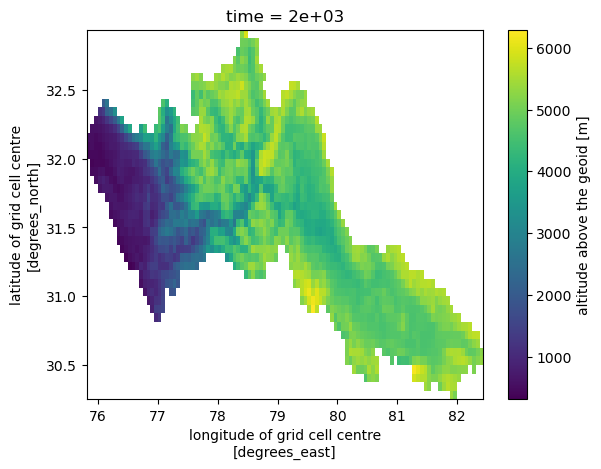

In [77]:
msk_hr_data_ds.isel(time=0).elevation.plot()

In [78]:
hr_data_ds

<xarray.Dataset>
Dimensions:    (time: 2, lon: 128, lat: 80)
Coordinates:
  * time       (time) float64 2e+03 2e+03
  * lon        (lon) float32 75.03 75.09 75.16 75.22 ... 82.78 82.84 82.91 82.97
  * lat        (lat) float32 29.03 29.09 29.16 29.22 ... 33.78 33.84 33.91 33.97
    latitude   (lat) float32 ...
    longitude  (lon) float32 ...
Data variables:
    tp         (time, lon, lat) float64 nan nan nan nan nan ... nan nan nan nan
    elevation  (lat, lon) int16 ...

In [79]:
hr_data_df = hr_data_ds.to_dataframe().dropna().reset_index()

In [80]:
hr_data_df

,time,lon,lat,tp,latitude,longitude,elevation
0,2000.041667,76.03125,31.78125,3.780316,31.78125,76.03125,591
1,2000.041667,76.03125,31.84375,3.776101,31.84375,76.03125,734
2,2000.041667,76.03125,31.90625,3.771887,31.90625,76.03125,583
3,2000.041667,76.03125,31.96875,3.767673,31.96875,76.03125,410
4,2000.041667,76.03125,32.03125,3.819520,32.03125,76.03125,407
...,...,...,...,...,...,...,...
3483,2000.125000,82.40625,30.71875,1.207233,30.71875,82.40625,5528
3484,2000.125000,82.46875,30.53125,1.475180,30.53125,82.46875,5201
3485,2000.125000,82.46875,30.59375,1.384979,30.59375,82.46875,5211
3486,2000.125000,82.46875,30.65625,1.294779,30.65625,82.46875,5341


In [ ]:
# Prepare data

# Transformations
lf_train_df['tp_tr'], lf_lambda = sp.stats.boxcox(
    lf_train_df['tp'].values + 0.01)
hf_train_df['tp_tr'] = sp.stats.boxcox(
    hf_train_df['tp'].values + 0.01, lmbda=lf_lambda)

# Splitting
x_train_lf = lf_train_df[['time', 'lat', 'lon', 'z']].values.reshape(-1, 4)
y_train_lf = lf_train_df['tp_tr'].values.reshape(-1, 1)
x_train_hf = hf_train_df[['time', 'lat', 'lon', 'z']].values.reshape(-1, 4)
y_train_hf = hf_train_df[['tp_tr']].values.reshape(-1, 1)
x_val = hr_data_df[['time', 'lat', 'lon', 'elevation']].values.reshape(-1, 4)


# Scaling
scaler = StandardScaler().fit(x_train_hf)
x_train_hf1 = scaler.transform(x_train_hf)
x_train_lf1 = scaler.transform(x_train_lf)
x_val1 = scaler.transform(x_val)

# Input data
X_train, Y_train = convert_xy_lists_to_arrays([x_train_lf1[:], x_train_hf1[:]], [y_train_lf[:], y_train_hf[:]])

# Train and evaluate
kern1 = GPy.kern.RBF(input_dim=4, ARD=True)
kernels = [kern1, GPy.kern.RBF(input_dim=4, ARD=True)]
lin_mf_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)
gpy_lin_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_mf_kernel, n_fidelities=2,)
gpy_lin_mf_model.mixed_noise.Gaussian_noise.fix(0)
gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0)
lin_mf_model = GPyMultiOutputWrapper(gpy_lin_mf_model, 2, n_optimization_restarts=5)
lin_mf_model.optimize()

# ALL
n = x_val.shape[0]
x_met = convert_x_list_to_array([x_val1, x_val1])
y_pred0, y_var0 = lin_mf_model.predict(x_met[n:])
y_pred_low, y_var_low = lin_mf_model.predict(x_met[:n])

 /var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_30363/699196541.py:4: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 13.826524908219426
Optimization restart 2/5, f = 537.3945768233389


In [ ]:
# ALL
y_pred = sp.special.inv_boxcox(y_pred0, lf_lambda).reshape(-1)

In [ ]:
hr_data_df['pred'] = y_pred

In [ ]:
hr_data_df['pred'].hist(bins=30)

In [ ]:
hr_data_df['tp'].hist(bins=30)

<AxesSubplot: >

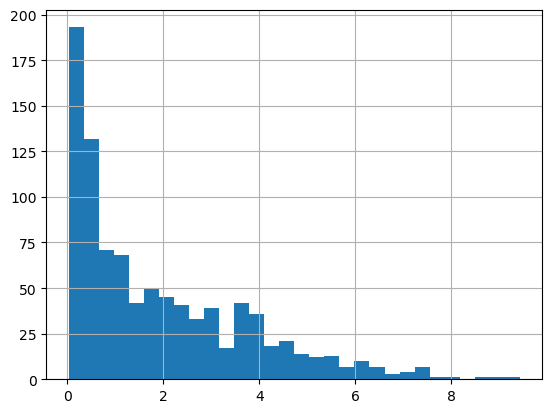

In [27]:
lf_train_df['tp'].hist(bins=30)

<AxesSubplot: xlabel='lon', ylabel='lat'>

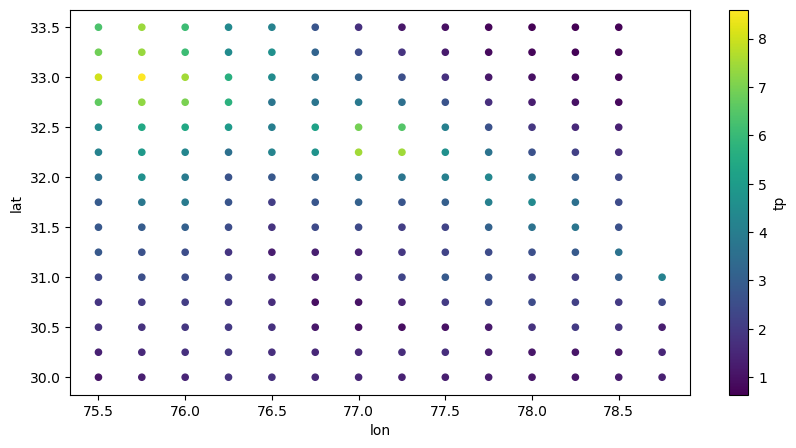

In [28]:
lf_train_df[:200].plot.scatter(x='lon', y='lat', c='tp',figsize=(10,5))

In [ ]:
hr_data_df[:1785].plot.scatter(x='lon', y='lat', c='pred', vmax=5, figsize=(10,5))

In [29]:
x_val = hr_data_df[['time', 'lat', 'lon', 'elevation']].values.reshape(-1, 4)
x_val1 = scaler.transform(x_val)

In [117]:
# ALL
n = x_val.shape[0]
x_met = convert_x_list_to_array([x_val1, x_val1])
y_pred0, y_var0 = lin_mf_model.predict(x_met[n:])
y_pred_low, y_var_low = lin_mf_model.predict(x_met[:n])

In [118]:
y_pred0.shape

(19308, 1)

In [119]:
y_pred = sp.special.inv_boxcox(y_pred0, lf_lambda).reshape(-1)

In [120]:
hr_data_df['pred'] = y_pred